## REFORMAT DATASET 
- Combining 15 years worth of Natural Disaster Data from the National Oceanic and Atmospheric Administration.
- Restricting dataset to only analyze the tornado sub-group

### Library Imports

In [77]:
#LIBRARY IMPORTS
import pandas as pd
import numpy as np
import seaborn as sns

#LIBRARY IMPORTS - PreProcessing And Visualizations
from sklearn import preprocessing as prep
import matplotlib.pyplot as plt

#LIBRARY IMPORTS - Oversampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

#LIBRARY IMPORTS - Correlation Matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#LIBRARY IMPORTS - Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

### Combining Natural Disaster Datasets

In [2]:
#COMBINING ALL THE STORM DETAILS FROM THE YEARS 2007 - 2022
#Initialize the dataset with the details from 2007, first.
NaturalDisaster_Data = pd.read_csv("./Storm Dataset/StormDetails2007.csv")

#Iterate through all the Storm Details years and combine datasets to create one single large one
for year in range(2007, 2023):
    currentYear_Data = pd.read_csv(f"./Storm Dataset/StormDetails{year}.csv")
    NaturalDisaster_Data = pd.concat([NaturalDisaster_Data, currentYear_Data])



In [3]:
#After combining all Nautral disaster data, only keep the Tornado subset of information.
#Side Note: Dimensions = 23,580 Rows;
NaturalDisaster_Data = NaturalDisaster_Data.loc[NaturalDisaster_Data['EVENT_TYPE'] == "Tornado"]

## DATA ANALYSIS / UNDERSTANDING

### Distribution of Data
- Checking the distribution of the data and analyzing specific info about percentage of null values and outliers
- Providing Data Quality Report

In [88]:
#Copying the data into a temporary array to prevent obstructing the original dataset; Printing out info
#SIDE NOTE: WILL GO BACK AND CHANGE THIS TO ORIGINAL WHEN FINISHED WITH ALL CODE

disaster_df = NaturalDisaster_Data.copy(deep=True)
disaster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23580 entries, 166 to 68702
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BEGIN_YEARMONTH     23580 non-null  int64  
 1   BEGIN_DAY           23580 non-null  int64  
 2   BEGIN_TIME          23580 non-null  int64  
 3   END_YEARMONTH       23580 non-null  int64  
 4   END_DAY             23580 non-null  int64  
 5   END_TIME            23580 non-null  int64  
 6   EPISODE_ID          23580 non-null  int64  
 7   EVENT_ID            23580 non-null  int64  
 8   STATE               23580 non-null  object 
 9   STATE_FIPS          23580 non-null  int64  
 10  YEAR                23580 non-null  int64  
 11  MONTH_NAME          23580 non-null  object 
 12  EVENT_TYPE          23580 non-null  object 
 13  CZ_TYPE             23580 non-null  object 
 14  CZ_FIPS             23580 non-null  int64  
 15  CZ_NAME             23580 non-null  object 
 16  WF

In [90]:
#Calculating percent of Missing values for each column
#Any columns with greater than 60% missing values will be dropped in pre-processing, Anything less will be dealt with mean imputation
datasetLength = len(disaster_df)
dataColumns = disaster_df.columns.values
df_drop_columns = []
df_impute_columns = []

for column in dataColumns:
    count = disaster_df[column].isnull().sum()
    percent = (count / datasetLength) * 100

    if percent > 0:
        if percent > 60:
            df_drop_columns.append(column) #Columns dropped if missing > 60%
        else:
            df_impute_columns.append(column) #Columns mean imputed

    print(column, ": {Count = ", count, ", Percent = ", percent, "}")

disaster_df = disaster_df.drop(columns= df_drop_columns) #Complete Case Analysis


BEGIN_YEARMONTH : {Count =  0 , Percent =  0.0 }
BEGIN_DAY : {Count =  0 , Percent =  0.0 }
BEGIN_TIME : {Count =  0 , Percent =  0.0 }
END_YEARMONTH : {Count =  0 , Percent =  0.0 }
END_DAY : {Count =  0 , Percent =  0.0 }
END_TIME : {Count =  0 , Percent =  0.0 }
EPISODE_ID : {Count =  0 , Percent =  0.0 }
EVENT_ID : {Count =  0 , Percent =  0.0 }
STATE : {Count =  0 , Percent =  0.0 }
STATE_FIPS : {Count =  0 , Percent =  0.0 }
YEAR : {Count =  0 , Percent =  0.0 }
MONTH_NAME : {Count =  0 , Percent =  0.0 }
EVENT_TYPE : {Count =  0 , Percent =  0.0 }
CZ_TYPE : {Count =  0 , Percent =  0.0 }
CZ_FIPS : {Count =  0 , Percent =  0.0 }
CZ_NAME : {Count =  0 , Percent =  0.0 }
WFO : {Count =  0 , Percent =  0.0 }
BEGIN_DATE_TIME : {Count =  0 , Percent =  0.0 }
CZ_TIMEZONE : {Count =  0 , Percent =  0.0 }
END_DATE_TIME : {Count =  0 , Percent =  0.0 }
INJURIES_DIRECT : {Count =  0 , Percent =  0.0 }
INJURIES_INDIRECT : {Count =  0 , Percent =  0.0 }
DEATHS_DIRECT : {Count =  0 , Percent 

## DATA PRE-PROCESSING
- Dealing with missing values using complete case analysis and mean imputation
- Cleaning up the data in terms of normalization, feature selection, and ordinally categorizing the target variable
- Creating data quality report on cleaned up data and checking visualizations to test distribution

### Feature Selection - Irrelevant Columns

In [91]:
#Dropping Columns with irrelevant and repetitive information relating to tornadoes and their magnitude/frequency
irrelevant_cols = ['BEGIN_AZIMUTH', 'END_AZIMUTH', 'BEGIN_LOCATION', 'END_LOCATION', 'CZ_NAME', 
                    'BEGIN_YEARMONTH', 'END_YEARMONTH', 'EVENT_NARRATIVE', 'EPISODE_NARRATIVE',
                    'BEGIN_DATE_TIME', 'END_DATE_TIME', 'EVENT_TYPE', 'CZ_TYPE', 'DATA_SOURCE']
disaster_df = disaster_df.drop(columns= irrelevant_cols)

### Transformations

In [92]:
#Encoding the numerical strings of Damage Property And Damage Crops into numerical dollar values
# temp_df["DAMAGE_PROPERTY"] = temp_df["DAMAGE_PROPERTY"].fillna(0.0)
# temp_df["DAMAGE_CROPS"] = temp_df["DAMAGE_CROPS"].fillna(0.0)

def transform_DamageCost(damage_data, damage_column):
    damage = pd.DataFrame(damage_data)
    for index,row in damage.iterrows():
        if type(row[damage_column]) != type(0.0):
            cost = row[damage_column]
            if cost[-1:] == 'B':
                row[damage_column] = float(cost[:-1])*1000000000
            elif cost[-1:] == 'M':
                row[damage_column] = float(cost[:-1])*1000000
            elif cost[-1:] == 'K':
                row[damage_column] = float(cost[:-1])*1000

    return damage

disaster_df["DAMAGE_PROPERTY"] = transform_DamageCost(disaster_df["DAMAGE_PROPERTY"], "DAMAGE_PROPERTY")
disaster_df["DAMAGE_CROPS"] = transform_DamageCost(disaster_df["DAMAGE_CROPS"], "DAMAGE_CROPS")

#Converting the data type
disaster_df['DAMAGE_PROPERTY'] = disaster_df['DAMAGE_PROPERTY'].astype('float') 
disaster_df['DAMAGE_CROPS'] = disaster_df['DAMAGE_CROPS'].astype('float')

In [93]:
#Transforming the TOR_F_Scale into numerical, ordinal data that takes into account the magnitude of the tornadoes
#Ordinal Values: EF0 = 0 --> EF5 = 5
tornado_scale = pd.DataFrame(disaster_df["TOR_F_SCALE"])

for index, row in tornado_scale.iterrows():
    scale = row["TOR_F_SCALE"]
    if scale[-1:] == '0' or scale[-1:] == 'U':
        row["TOR_F_SCALE"] = 0
    elif scale[-1:] == '1':
        row["TOR_F_SCALE"] = 1
    elif scale[-1:] == '2':
        row["TOR_F_SCALE"] = 2
    elif scale[-1:] == '3':
        row["TOR_F_SCALE"] = 3
    elif scale[-1:] == '4':
        row["TOR_F_SCALE"] = 4
    elif scale[-1:] == '5':
        row["TOR_F_SCALE"] = 5

disaster_df["TOR_F_SCALE"] = tornado_scale
disaster_df['TOR_F_SCALE'] = disaster_df['TOR_F_SCALE'].astype('int') #Converting the data type

#### Data Quality Report For Categorical And Continuous Features Before Encoding


In [96]:
#NOTE: DATA QUALITY REPORT FOR CATEGORICAL VARIABLES PRIOR TO ENCODING

dqr_categ = pd.DataFrame(columns=['Feature', 'Description', 'Count', '% Missing', 'Cardinality','Mode',
'Mode Frequency', 'Mode %', '2nd Mode', '2nd Mode Frequency', '2nd Mode %'])

descriptions = ['State where tornado occured', 'Year of occurence', 'Month of occurence', 
                'National Weather Service Area Of Occurence', 'Timezone of where tornado occured','Source reporting the weather event']

dqr_categ['Feature'] = ['STATE', 'YEAR', 'MONTH_NAME', 'WFO', 'CZ_TIMEZONE', 'SOURCE']

for index, row in dqr_categ.iterrows():
    row['Description'] = descriptions[index]
    row['Count'] = disaster_df[row['Feature']].count()
    row['Cardinality'] = len(disaster_df[row['Feature']].unique())
    row['Mode'] = disaster_df[row['Feature']].mode()[0]
    row['% Missing'] = round((len(disaster_df[disaster_df[row['Feature']]==None])/row['Count'])*100, 2)
    row['Mode Frequency'] = len(disaster_df[disaster_df[row['Feature']]==row['Mode']])
    row['Mode %'] = round(row['Mode Frequency']/row['Count']*100, 2)
    mode_df = disaster_df[disaster_df[row['Feature']]!=row['Mode']]
    row['2nd Mode'] = mode_df[row['Feature']].mode()[0]
    row['2nd Mode Frequency'] = len(mode_df[mode_df[row['Feature']]==row['2nd Mode']])
    row['2nd Mode %'] = round(row['2nd Mode Frequency']/row['Count']*100, 2)

dqr_categ

,Feature,Description,Count,% Missing,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,STATE,State where tornado occured,23580,0.0,52,TEXAS,2290,9.71,KANSAS,1613,6.84
1,YEAR,Year of occurence,23580,0.0,16,2007,2482,10.53,2011,2074,8.8
2,MONTH_NAME,Month of occurence,23580,0.0,12,May,5080,21.54,April,4332,18.37
3,WFO,National Weather Service Area Of Occurence,23580,0.0,118,JAN,1158,4.91,OUN,844,3.58
4,CZ_TIMEZONE,Timezone of where tornado occured,23580,0.0,6,CST-6,16406,69.58,EST-5,5217,22.12
5,SOURCE,Source reporting the weather event,23580,0.0,29,NWS Storm Survey,15292,64.85,Emergency Manager,1575,6.68


In [ ]:
#NOTE: DATA QUALITY REPORT FOR ALL CONTINUOUS FEATURES PRIOR TO ENCODING
## DQR for continuous variables


#### Transformations After Encoding Categorical

In [45]:
#NOTE: Encoding Categorical Data into Continuous to prepare for classifier and test distribution
labelEncode = prep.LabelEncoder()
disaster_df['STATE'] = labelEncode.fit_transform(disaster_df['STATE'])
disaster_df['MONTH_NAME'] = labelEncode.fit_transform(disaster_df['MONTH_NAME'])
disaster_df['WFO'] = labelEncode.fit_transform(disaster_df['WFO'])
disaster_df['CZ_TIMEZONE'] = labelEncode.fit_transform(disaster_df['CZ_TIMEZONE'])
disaster_df['SOURCE'] = labelEncode.fit_transform(disaster_df['SOURCE'])


In [46]:
#Converting all values measuring longitude and latititue into positive values to prepare for correlation matrix
disaster_df['BEGIN_LON'] = abs(disaster_df['BEGIN_LON'])
disaster_df['END_LON'] = abs(disaster_df['END_LON'])

### Missing Values And Outliers

In [47]:
df_impute_columns = list(set(df_impute_columns) - set(irrelevant_cols))
for column in df_impute_columns:
    df_mean = disaster_df[column].mean()
    disaster_df[column] = disaster_df[column].fillna(df_mean) #Mean Imputation
    

### Data Visualization - Testing Distributions

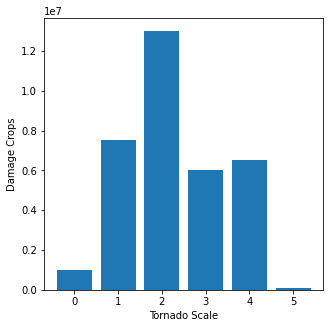

In [18]:
#NOTE: Visualizing the distribution of damage property on the tornado scale
plt.figure(figsize=(5,5))
plt.bar(disaster_df['TOR_F_SCALE'], disaster_df['DAMAGE_CROPS'], label = 'Damage_Crops')
plt.xlabel('Tornado Scale')
plt.ylabel('Damage Crops')
plt.show()

In [ ]:
#NOTE: Visualizing the distribution of damage property on the tornado scale
plt.figure(figsize=(5,5))
plt.bar(disaster_df['TOR_F_SCALE'], disaster_df['DAMAGE_PROPERTY'], label = 'Damage_Property')
plt.xlabel('Tornado Scale')
plt.ylabel('Damage Property')
plt.show()

In [ ]:
#NOTE: Visualizing potential outliers in each feature
disaster_cols = list(disaster_df.columns)
disaster_cols.remove('DAMAGE_PROPERTY')
disaster_cols.remove('DAMAGE_CROPS')
disaster_cols.remove('EPISODE_ID')
disaster_cols.remove('EVENT_ID')
disasterDf_boxplot = disaster_df.boxplot(column= disaster_cols, figsize=(50,15))

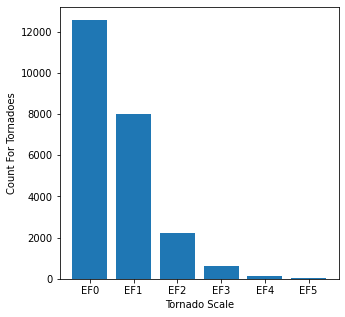

In [49]:
#NOTE: Visualizing the amount of tornadoes that are grouped in each tornado scale EF0 - EF5
magnitude_counts = []
for scale in range(6):
    magnitude = len(disaster_df[disaster_df['TOR_F_SCALE'] == scale])
    magnitude_counts.append(magnitude)

plt.figure(figsize=(5,5))
plt.bar(['EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5'], magnitude_counts, label = 'Amount Of Tornadoes')
plt.xlabel('Tornado Scale')
plt.ylabel('Count For Tornadoes')
plt.show()

### Normalization


In [17]:
#NOTE: Normalizing the features in the dataset to prepare for classification models due to variety in ranges in correlated features
#Applied logarithmic normalization
disaster_df.apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(2))

,BEGIN_DAY,BEGIN_TIME,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,...,SOURCE,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,BEGIN_RANGE,END_RANGE,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON
166,-1.75,-0.69,-1.75,-0.70,-1.43,-1.43,-1.06,-1.05,-1.44,0.24,...,-0.10,-0.78,-0.61,-0.53,-0.36,-0.36,-2.60,-1.29,-2.60,-1.28
263,-0.17,-1.72,-0.17,-1.72,-1.50,-1.50,-1.06,-1.05,-1.44,-1.50,...,-0.10,1.68,-0.38,0.39,-0.61,-0.62,-1.37,-1.20,-1.37,-1.19
558,-0.17,-1.16,-0.17,-1.16,-1.50,-1.50,-1.06,-1.05,-1.44,-1.50,...,1.18,0.45,-0.69,-0.46,-0.36,-0.36,-1.54,-1.32,-1.54,-1.32
656,0.62,0.26,0.62,0.25,-1.36,-1.37,-0.01,0.01,-1.44,1.41,...,-0.10,0.45,0.09,-0.12,-0.36,-0.62,-0.76,-0.17,-0.76,-0.17
736,-0.17,1.30,-0.17,1.30,-1.49,-1.49,0.76,0.75,-1.44,0.83,...,-0.10,-0.78,-0.70,-0.53,-0.10,-0.11,0.61,-1.01,0.60,-1.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68627,-0.51,1.14,-0.51,1.13,1.73,1.74,0.83,0.81,1.64,-0.92,...,-0.10,-0.78,-0.45,-0.46,-0.61,-0.36,-0.09,1.08,-0.09,1.08
68676,-0.28,-0.00,-0.28,-0.00,1.73,1.74,-1.62,-1.79,1.64,-0.92,...,-0.10,0.45,0.31,0.14,0.15,-0.11,-0.98,-0.45,-0.98,-0.45
68680,-0.28,0.07,-0.28,0.06,1.72,1.74,-0.01,0.01,1.64,-0.92,...,-0.10,-0.78,-0.46,-0.46,-0.61,-0.62,-1.33,-0.32,-1.33,-0.31
68681,-0.28,0.44,-0.28,0.44,1.72,1.74,-0.01,0.01,1.64,-0.92,...,-0.10,0.45,-0.19,-0.29,-0.61,-0.36,-1.40,-0.37,-1.40,-0.36


## FEATURE SELECTION - CORRELATION MATRIX

### Correlation Matrix

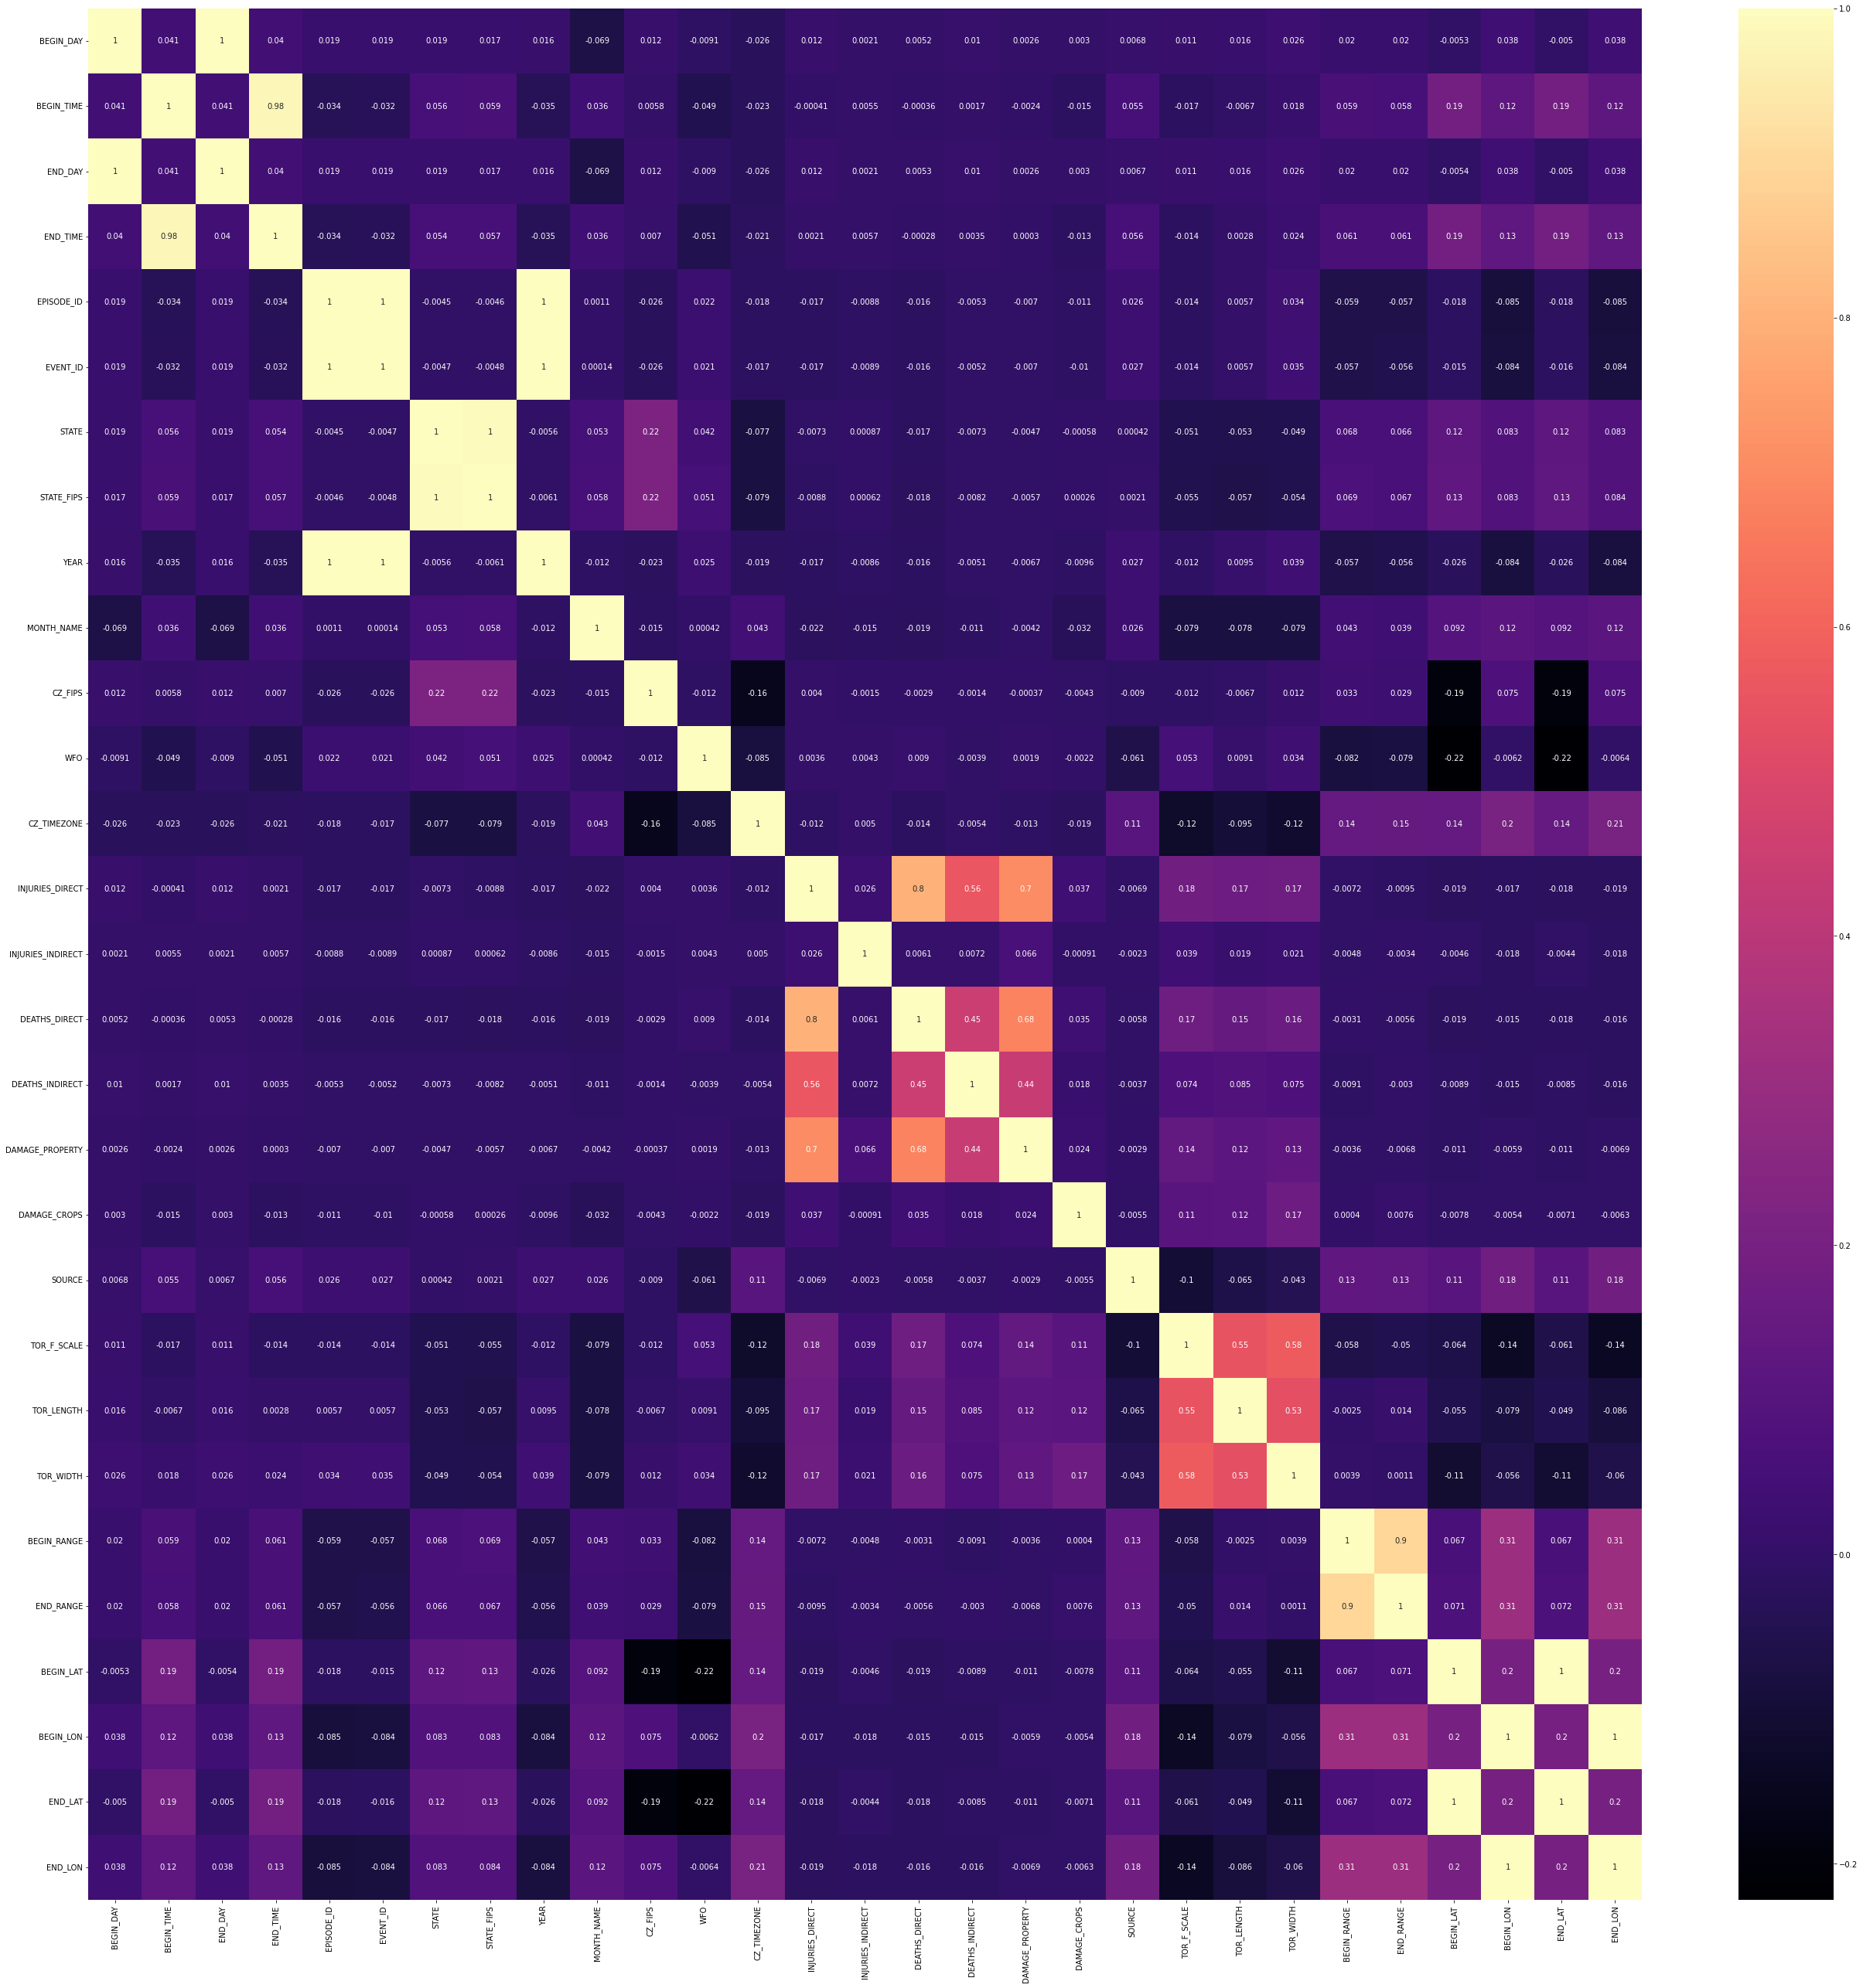

In [69]:
X = disaster_df.iloc[:,0:30]
y = disaster_df['TOR_F_SCALE']
#get correlations of each features in dataset
corrmat = disaster_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(45,45))
#plot heat map
g=sns.heatmap(disaster_df[top_corr_features].corr(),annot=True,cmap="magma")

### Scoring Top 15 Best Features

In [71]:
#Columns
X = disaster_df.iloc[:, 0:34]
y = disaster_df['TOR_F_SCALE']

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(15,'Score'))  #print 10 best features

                Specs         Score
17    DAMAGE_PROPERTY  1.828821e+12
18       DAMAGE_CROPS  1.161608e+09
5            EVENT_ID  2.430188e+07
4          EPISODE_ID  4.013504e+06
22          TOR_WIDTH  3.970168e+06
13    INJURIES_DIRECT  6.723610e+05
15      DEATHS_DIRECT  1.436125e+05
21         TOR_LENGTH  4.157433e+04
20        TOR_F_SCALE  2.449341e+04
3            END_TIME  7.709221e+03
1          BEGIN_TIME  7.301695e+03
14  INJURIES_INDIRECT  3.046487e+03
11                WFO  2.399343e+03
10            CZ_FIPS  1.326965e+03
16    DEATHS_INDIRECT  1.175387e+03


In [72]:
#Cutting down the dataset to only include the top 15 features 
disasterDf_correlated = disaster_df[['DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'EVENT_ID', 'EPISODE_ID', 'TOR_WIDTH', 'INJURIES_DIRECT','DEATHS_DIRECT','TOR_LENGTH',
                                'TOR_F_SCALE', 'END_TIME', 'BEGIN_TIME', 'INJURIES_INDIRECT','DEATHS_INDIRECT','WFO','CZ_FIPS']]
disasterDf_correlated.head()

,DAMAGE_PROPERTY,DAMAGE_CROPS,EVENT_ID,EPISODE_ID,TOR_WIDTH,INJURIES_DIRECT,DEATHS_DIRECT,TOR_LENGTH,TOR_F_SCALE,END_TIME,BEGIN_TIME,INJURIES_INDIRECT,DEATHS_INDIRECT,WFO,CZ_FIPS
166,2.000000e+04,0.000000,45063,7822,30.0,0,0,0.55,0,1156,1155,0,0,59,87
263,1.472746e+06,9901.112118,22128,3951,300.0,0,0,1.50,2,615,615,0,0,57,3
558,1.472746e+06,9901.112118,22131,3951,50.0,0,0,0.20,1,910,910,0,0,57,109
656,1.800000e+05,0.000000,64108,11659,150.0,0,0,3.47,1,1659,1654,0,0,56,133
736,2.000000e+04,0.000000,25721,4525,30.0,0,0,0.15,0,2210,2205,0,0,52,23


## DATA MODELS AND EVALUATION

### OverSampling Target Feature

In [66]:
#NOTE: Oversampling minority scales due to the imbalance between counts of each tornado scale
len_majorityEF = magnitude_counts[0]

#Defining parameters for classifiers by oversampling tor_f_Scale magnitudes
#Split data into features X and target Y
X = disasterDf_correlated.drop('TOR_F_SCALE', axis=1)
y = disasterDf_correlated['TOR_F_SCALE']

# summarize class distribution
print(Counter(y))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

Counter({0: 12563, 1: 8021, 2: 2238, 3: 609, 4: 134, 5: 15})
Counter({0: 12563, 5: 12563, 1: 8021, 2: 2238, 3: 609, 4: 134})


### Random Forest Classifier

In [57]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8419595903681152


In [67]:
#Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm

,0,1,2,3,4,5
0,2176,326,4,0,0,0
1,388,1109,67,5,0,0
2,27,214,182,10,1,0
3,1,20,51,42,3,1
4,0,0,11,13,4,0
5,0,0,0,0,0,2571


In [68]:
#EVALUATING THE CLASSIFIER
print('Precision: %.3f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average = 'micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average = 'micro'))

Precision: 0.842
Recall: 0.842
F1 Score: 0.842


### Gaussian Naive Bayes Model

In [75]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2)

gaussNb = GaussianNB() #Applying the Gaussian Classifier
gaussNb.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred) #Printing Accuracy Scores
print("Accuracy:", accuracy)

Accuracy: 0.9688624411846112


In [76]:
#Confusion Matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
cm

,0,1,2,3,4,5
0,2435,63,1,0,0,0
1,74,1516,16,1,0,0
2,5,48,415,4,0,0
3,0,2,7,109,1,1
4,0,0,1,1,26,0
5,0,0,0,0,0,2500


In [78]:
#EVALUATING THE CLASSIFIER
print('Precision: %.3f' % precision_score(y_test, y_pred, average='micro'))
print('Recall: %.3f' % recall_score(y_test, y_pred, average = 'micro'))
print('F1 Score: %.3f' % f1_score(y_test, y_pred, average = 'micro'))

Precision: 0.969
Recall: 0.969
F1 Score: 0.969
